In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

np.set_printoptions(suppress=True, precision=4)

In [2]:
class Policy(nn.Module):

    def __init__(self, num_classes, lr):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(4, 8)
#         self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(8, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=0) #important param to set --> dim
        self.optimizer = optim.SGD(self.parameters(), lr=lr)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

def makePolicyNN(num_actions=2, lr=0.01):
    ''' Initialize the policy class '''
    assert isinstance(num_actions, int) and num_actions>0
    
    return Policy(num_actions, lr)

In [3]:
class PolicyGradient:
    def __init__(self, gamma, N=200, max_steps=500):
        ''' Initialize the cart-pole environment '''
        assert isinstance(gamma, float) and 0.0<gamma<1.0, 'Invalid gamma'
        assert isinstance(N, int) and N>0
        assert isinstance(max_steps, int) and max_steps>0
        
        self.env = gym.make ("CartPole-v1")
        self.gamma = gamma
        self.N = N
        self.max_steps = max_steps
        self.numActions = self.env.action_space.n
        self.num_steps = 0
        self.max_steps_reached = False
    
    def getAction(self, policy_network, state):
        ''' Return an action from a stochastic policy '''
        assert isinstance(state, np.ndarray) and len(state) == 4
        
        state = torch.from_numpy(state).float()
        probs = policy_network(state)
        m = Categorical(probs)
        action = m.sample() #type tensor
        log_prob_of_action = m.log_prob(action) #type tensor
        action = action.item() #extracting value from tensor
        
        assert isinstance(action, int) and action in [0,1]
        
        return action, log_prob_of_action
    
    def runEpisode(self, policy_network):
        ''' Generate [s_t, a_t, r_t] pairs for one episode '''
        
        state = self.env.reset()
        done = False
        rewards, log_prob_of_actions = [], []
        while not(done):
            a, lpa = self.getAction(policy_network, state)
            state, r, done, info = self.env.step(a)
            r = rewards.append(r)
            log_prob_of_actions.append(lpa)
            self.num_steps += 1 #incrementing total number of steps in one iteration
            if self.num_steps >= self.max_steps: #checking
                self.max_steps_reached = True
                break;
        
        return rewards, log_prob_of_actions    
    
    def doReinforcePart1(self, policy_network, verbose=False):
        ''' Improve policy by implementing vanilla version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                # Calculate discounted return (G_tau) and summation of log probs of actions from the episode
                G_tau = sum([ r[t] * gamma**t for t in range(len(r))])
                sum_lpa = sum(log_prob_of_actions)
                objective += G_tau * sum_lpa
                assert isinstance(objective, torch.Tensor)

#             if verbose:
#                 print('objective, n = ', objective.item(), n)

            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1}'.format(i, objective))

        return policy_network, arr_objective
    
    def doReinforcePart2(self, policy_network, verbose=False):
        ''' Improve policy by implementing an imporved version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                
                # Calculate discounted return (G_tau) and summation of log probs of actions from the episode
                T = len(r)
                for t in range(T):
                    future_discounted_return = 0
                    for t_prime in range(t, T):
                        future_discounted_return += r[t_prime] * gamma**(t_prime - t)
                    objective += log_prob_of_actions[t]*future_discounted_return

                assert isinstance(objective, torch.Tensor)

            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1}'.format(i, objective))

        return policy_network, arr_objective

    def doReinforcePart3(self, policy_network, verbose=False):
        ''' Improve policy by implementing an imporved version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                
                # Calculate discounted return (G_tau) and summation of log probs of actions from the episode
                T = len(r)
                b = mean(r)
                for t in range(T):
                    future_discounted_return = 0
                    for t_prime in range(t, T):
                        future_discounted_return += r[t_prime]*gamma**(t_prime - t) - b
                    objective += log_prob_of_actions[t]*future_discounted_return

                assert isinstance(objective, torch.Tensor)

            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1}'.format(i, objective))

        return policy_network, arr_objective

# Need to calculate $ J(\theta) \approx 1/N \sum_{i=0}^{N} G(\tau_{i}) \sum_{t=0}^{T} log\pi_{\theta}(a_{t} | s_{t}) $
## $ G(\tau_{i}) = \sum_{t=0}^{T} \gamma^{t}r_{t}$

Iteration: 0 	 Objective: -123.98538208007812
Iteration: 20 	 Objective: -174.39895629882812
Iteration: 40 	 Objective: -102.77055358886719
Iteration: 60 	 Objective: -79.99299621582031
Iteration: 80 	 Objective: -62.62907791137695
Iteration: 100 	 Objective: -47.43647766113281
Iteration: 120 	 Objective: -72.59705352783203
Iteration: 140 	 Objective: -58.354957580566406
Iteration: 160 	 Objective: -62.1779899597168
Iteration: 180 	 Objective: -49.67301559448242


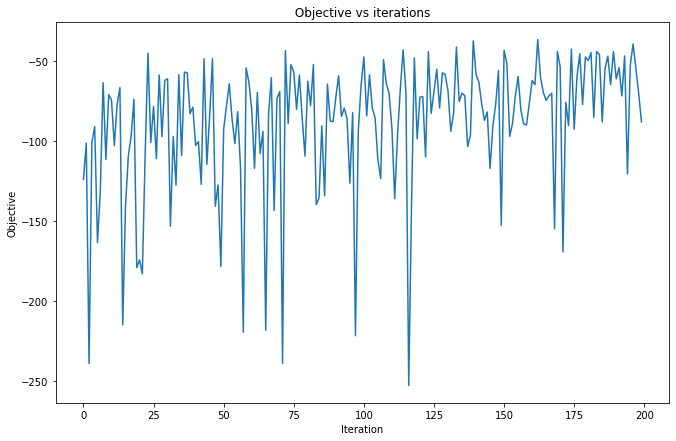

/Users/adnanshahpurwala/anaconda3/envs/ece276c_venv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
if __name__ == '__main__':
    render_env = True
    plot = True
#     ## Part 1 (vanilla REINFORCE)
#     policy_network = makePolicyNN(num_actions=2, lr=3e-4)
#     pg = PolicyGradient(gamma=0.9, N = 100)
#     policy_network, arr_objective = pg.doReinforcePart1(policy_network, verbose=True)
    
#     ## Part 2 (future discounted returns) 
#     policy_network = makePolicyNN(num_actions=2, lr=1e-4)
#     pg = PolicyGradient(gamma=0.9, N = 200, max_steps=500)
#     policy_network, arr_objective = pg.doReinforcePart2(policy_network, verbose=True)
    
    ## Part 3 (future discounted returns - bias) 
    policy_network = makePolicyNN(num_actions=2, lr=1e-4)
    pg = PolicyGradient(gamma=0.9, N = 200, max_steps=500)
    policy_network, arr_objective = pg.doReinforcePart3(policy_network, verbose=True)
    if plot:
        fig, ax = plt.subplots(figsize=(11,7))
        ax.plot(arr_objective)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Objective')
        ax.set_title(' Objective vs iterations ')
        plt.show()
    
    if render_env:
        steps = 0
        state = pg.env.reset()
        done = False
        while steps<200:
            a, _ = pg.getAction(policy_network, state)
            state, r, done, info = pg.env.step(a)
            steps+=1
#             print('steps = ', steps)
            pg.env.render()
        pg.env.env.close()